# Bundle Adjustment

Part of this assignment is based on scipy-cookbook. It will take around 2 hours to finish.

# Question 1: Reading

1. Read the paper 'Building Rome in a Day' and briefly write about the fundamental idea behind the problem and solution. No need to be verbose, just write about the challenge with the task and how the pipeline is implemented (do not include details about performance/parallelization).

The paper ‘Building Rome In A Day’ details the construction of a system that uses extremely large collections of unstructured images from the internet in order to match and reconstruct 3 Dimensional scenes on a city-wide scale by making use of a collection of parallelized distributed matching and reconstruction algorithms. This was done with the agenda of maximizing parallelism and minimizing serialization bottlenecks to reduce time so that the task of reconstructing a city could be performed in a day or less using 150,000 images on 500 computer cores. Another important aim was to scale the system gracefully depending on two factors - the available computational power and the size of the given problem. This system is one to two orders of magnitude larger than the next largest results reported in the literature. The system relies on existing state-of-the-art matching and SfM algorithms such as SIFT, vocabulary trees, and bundle adjustment.

Some of the challenges faced include:

Use of unstructured data from the internet instead of structured data: Structured data is obtained from the same calibrated camera, at a regular sampling rate and uses sensors such as GPS and Intertial Navigation Units which makes computation easier, whereas unstructured data is taken from various cameras, in varying illumination conditions, with very less geographic information and no camera calibration information.
Optimizing for memory usage and I/O bandwidth, while choosing algorithms that work well together, scale well and provide high performance. In some cases, the authors designed and implemented the algorithms themselves.
The system is currently dominated by the largest connected components for track generation, skeletal sets, and reconstruction algorithms.
Metadata such as the website and username are used to group images together which may or may not always be effective. A better strategy would exploit all the textual tags and geotags associated with the images to predict what images are likely to match and then distribute the data accordingly.
The system uses batch jobs, but it would be more effective if more images could be added to extend the system.
Scaling is a problem because multi-threading and parallelism are not implemented in all parts, and relies on the redundancy in various images. It also needs more optimization in the way images are distributed for processing.

The main stages of the pipeline are pre-processing, matching, and geometric estimation. A brief overview of the pipeline involves distributing N images on M processors. Next, SIFT feature extraction, vocabulary tree vector quantization, and term frequency counting are performed. After this, document frequency counting, TFIDF computation, and information broadcast are performed. This is followed by computing TF-based match likelihoods and aggregation at the master processor node. Next, the match verification tasks are distributed using a round-robin bin-packing method based on the top k1 matches per image. Finally, the match verification and match proposal expansion occur based on images found in connected components using the next best k2 matches per image. After further distributed verification, 4 more rounds of query expansion and verification and track merging from local verified matches, followed by track aggregation into C connected components, the tracks are finally distributed by image connected components and distributed merging.

 
Preprocessing:

In the preprocessing stage, images are distributed to cluster nodes from a central store so images can be downloaded independently of experiments on-demand in fixed-size chunks to perform load balancing. After verifying the image files, the EXIF tags are extracted and focal length is recorded. Larger images are downsampled while preserving aspect ratios and scaling focal lengths. They are converted to grayscale, SIFT features are extracted and the images are partitioned.

Matching:

A multi-stage matching scheme was used, where each stage involves a proposal and a verification step. The proposal involves determining a set of image pairs that are expected to share common scene elements, and the verification involves detailed feature matching. These matches are then used in the next proposal step. This system uses vocabulary trees and query expansion for proposals, and a greedy bin-packing algorithm to choose images to transfer to each node for verification. This involves photometric matching between feature descriptors, and an estimation of the essential or fundamental matrix depending upon the camera calibration information.


Geometric Estimation:

After track generation, the run structure is generated for every connected component. It is better to reconstruct a minimal subset of photographs that capture essential connectivity of the match graph and scene geometry. All remaining images can be added using pose estimation and a final bundle adjustment for refining SfM estimates. The authors use the skeletSLAM refers to simultaneous localization and mapping, and involves keeping track of the position of the robot as well as the environment around it. This is a difficult problem because it consists of a robot in an unknown environment that learns data about its environment, stores this information and keeps track of its own pose within that environment as well. It simultaneously solves the problem of localization (finding its own position) and mapping (creating a map of an unknown environment), which is impressive because the pose is needed for mapping, and a map is needed for localization. This is different from the problem described in the research paper because that does not involve localization, it involves finding matching various images and reconstructing an environment. In SLAM, the environment is unknown and the robot traverses this environment to gain information, whereas in the research paper, there is no robot, and a lot of known data from the internet is used with metadata that can help connect isolated components together and recreate various sections of a known environment by assembling them all together.al sets algorithm which computes the spanning set of photographs, and use this to estimate the SfM parameters of resulting components. The skeletal sets algorithms are used to give a larger set of components.

2. How is this task different from a SLAM problem?

SLAM refers to simultaneous localization and mapping, and involves keeping track of the position of the robot as well as the environment around it. This is a difficult problem because it consists of a robot in an unknown environment that learns data about its environment, stores this information and keeps track of its own pose within that environment as well. It simultaneously solves the problem of localization (finding its own position) and mapping (creating a map of an unknown environment), which is impressive because the pose is needed for mapping, and a map is needed for localization. This is different from the problem described in the research paper because that does not involve localization, it involves finding matching various images and reconstructing an environment. In SLAM, the environment is unknown and the robot traverses this environment to gain information, whereas in the research paper, there is no robot, and a lot of known data from the internet is used with metadata that can help connect isolated components together and recreate various sections of a known environment by assembling them all together.

# Question 2: Code!

### Task
We have a set of points in real world defined by their coordinates $(X, Y, Z)$ in some apriori chosen "world coordinate frame". We photograph these points by different cameras, which are characterized by their orientation and translation relative to the world coordinate frame and also by focal length and two radial distortion parameters (9 parameters in total). Then we precicely measure 2-D coordinates $(x, y)$ of the points projected by the cameras on images. Our task is to refine 3-D coordinates of original points as well as camera parameters, by minimizing the sum of squares of reprojecting errors.

We will be using a dataset from http://grail.cs.washington.edu/projects/bal/ for this task. Feel free to choose any of the ones mentioned on the page. Take the smallest file from each dataset (you can choose any but it will take longer to run, consume more memory)

In [1]:
import urllib
import copy
import bz2
import os
import numpy as np
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


First download the data file:

In [2]:
BASE_URL = "http://grail.cs.washington.edu/projects/bal/data/"

DATASET_NAME = "venice/"
FILE_NAME = "problem-89-110973-pre.txt.bz2"

URL = BASE_URL + DATASET_NAME + FILE_NAME

In [3]:
if not os.path.isfile(FILE_NAME):
    urllib.request.urlretrieve(URL, FILE_NAME)

Now read the data from the file:

In [4]:
def read_bal_data(file_name):
    with bz2.open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(
            int, file.readline().split())

        camera_indices = np.empty(n_observations, dtype=int)
        point_indices = np.empty(n_observations, dtype=int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = int(camera_index)
            point_indices[i] = int(point_index)
            points_2d[i] = [float(x), float(y)]

        camera_params = np.empty(n_cameras * 9)
        for i in range(n_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points * 3)
        for i in range(n_points * 3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))

    return camera_params, points_3d, camera_indices, point_indices, points_2d

In [5]:
camera_params, points_3d, camera_indices, point_indices, points_2d = read_bal_data(FILE_NAME)

In [6]:
print(f"camera_params: {camera_params.shape};\npoints_3d: {points_3d.shape};\n"
        f"camera_indices: {camera_indices.shape}; \npoint_indices: {point_indices.shape}; \n"
        f"points_2d: {points_2d.shape}")

camera_params: (89, 9);
points_3d: (110973, 3);
camera_indices: (562976,); 
point_indices: (562976,); 
points_2d: (562976, 2)


Here we have numpy arrays:

1. `camera_params` with shape `(n_cameras, 9)` contains initial estimates of parameters for all cameras. First 3 components in each row form a **rotation vector**, next 3 components form a translation vector, then a focal distance and two distortion parameters.
2. `points_3d` with shape `(n_points, 3)` contains initial estimates of point coordinates in the world frame.
3. `points_2d` with shape `(n_observations, 2)` contains measured 2-D coordinates of points projected on images in all the observations.
4. `camera_ind` with shape `(n_observations,)` gives the index of the camera (from 0 to `n_cameras - 1`) associated with a particular observation.   
5. `point_ind` with shape `(n_observations,)` contains indices of 3D points (from 0 to `n_points - 1`) involved in each observation.

# Visualise Point Cloud

Visualise `points_3d`. It may not look like 'Venice' or any building as we are working with a small subset.

In [7]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d)
pcd.paint_uniform_color([0.7,0,1])
o3d.visualization.draw_geometries([pcd])

# Extract Parameters

How many cameras and 3D points do we have? Calculate the number of parameters to estimate.

In [8]:
n_cameras = 89
n_points = 110973
m = 110973*2
n = 89*9 + 110973*3

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters to estimate: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 89
n_points: 110973
Total number of parameters to estimate: 333720
Total number of residuals: 221946


We chose a relatively small problem to reduce computation time, but scipy's algorithm is capable of solving much larger problems, although required time will grow proportionally.

Now define the function which returns a vector of residuals. We use numpy vectorized computations:

### A short review on Transformations

Rodrigues Formula: $$\mathbf{R}=\cos \theta \mathbf{I}+(1-\cos \theta) \mathbf{n n}^{\mathrm{T}}+\sin \theta \mathbf{n}^{\wedge}$$
If described by a rotation vector, assuming that the rotation axis is a unit length vector $\mathbf{n}$ and the angle is $\theta$, then the vector $\theta \mathbf{n}$ can also describe this rotation. Here, rot_vecs = $\theta \mathbf{n}$.

In [9]:
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis] #np.newaxis converts this into a column vector.
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    
    return (cos_theta * points) + ((1 - cos_theta) * v * dot) + (sin_theta * np.cross(v, points))

## A short review on camera modelling & radial distortion



- Each pixel moves radially away from (barrel) or towards (pincushion) the image center (c).
- As a function of distance from $c: r_{c}^{2}=x_{c}^{2}+y_{c}^{2}$.
- The shift $\gamma$ can be modelled as: $\gamma=1+k_{1} r_{c}^{2}+k_{2} r_{c}^{4}$ where ${k}_{1}$ and ${k}_{2}$ are radial distortion parameters.
- The modified co-ordinates are:

$$\begin{array}{l}
\hat{x}_{c}=\gamma x_{c} \\
\hat{y}_{c}=\gamma y_{c}
\end{array} 
$$

- **This is applied before the focal-length multiplier and center shift are applied**: Meaning before $K$ matrix is even applied. But how do we exactly do that?

    $$\mathbf{K}=\left[\begin{array}{ccc}\alpha_{x} & 0 & x_{0} \\0 & \alpha_{y} & y_{0} \\0 & 0 & 1\end{array}\right] ; \qquad      \lambda {p} = \mathrm{x} =K[R \quad t] \mathrm{X}$$

    $$x_{final} = \gamma \left(\frac{f_0X}{Z}+c_x \right)
     \qquad \color{red} \bigotimes \textbf{wrong}$$

    $$x_{final} =  \left(f_0 \left(\gamma\frac{X}{Z} \right)+c_x \right)
     \qquad \color{surd} \checkmark \textbf{correct}$$

### Summing it up
Let $\pmb{P} = (X, Y, Z)^T$ - a radius-vector of a point, $\pmb{R}$ - a rotation matrix of a camera, $\pmb{t}$ - a translation vector of a camera, $f$ - its focal distance, $k_1, k_2$ - its distortion parameters. Then the reprojecting is done as follows:

\begin{align}
\pmb{Q} = \pmb{R} \pmb{P} + \pmb{t} \\
\pmb{q} = -\begin{pmatrix} Q_x / Q_z \\ Q_y / Q_z \end{pmatrix} \\
\pmb{p} = f (1 + k_1 \lVert \pmb{q} \rVert^2 + k_2 \lVert \pmb{q} \rVert^4) \pmb{q}
\end{align}
The resulting vector $\pmb{p}=(x, y)^T$ contains image coordinates of the original point.
![radial_distortion_1.png](../misc/radial_distortion_1.png) 
![radial_distortion_2.png](../misc/radial_distortion_2.png)

In [10]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""
    X = points
    rot_vecs = np.array(camera_params[:,:3])
    t = np.array(camera_params[:,3:6])
    f = np.array(camera_params[:,6])
    k1 = np.array(camera_params[:,7])
    k2 = np.array(camera_params[:,8])
    Q = np.array(rotate(X, rot_vecs) + t)
    q = []
    det_q = []
    for i in range(len(Q)):
        a = -Q[i][0]/Q[i][2]
        b = -Q[i][1]/Q[i][2]
        q.append([a, b])
        det_q.append(a**2 + b**2)
    q = np.array(q)
    det_q = np.array(det_q)
    x = []
    for i in range(len(Q)):
        x.append(f[i]*(1 + k1[i]*(det_q[i]**2) + k2[i]*(det_q[i]**4))*q[i])
    x = np.array(x)
    
    return x

In [11]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """
    params = copy.deepcopy(params)
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()

## A short review on Structure from Motion
### Residual
In our lecture, in the residual vector, we  wrote the elements in order: 11, 12, 13.., 1N, then 21, 22.. and so on till MN. However, notice that it is not the case here.

M -> camera, N -> 3D point (in our lectures, NOT in this code)
![sfm_residual_1.png](../misc/sfm_residual_1.png)

You can see that computing Jacobian of `fun` is cumbersome, thus we will rely on the finite difference approximation. To make this process time feasible we provide Jacobian sparsity structure (i. e. mark elements which are known to be non-zero):

![sfm_jac_2.png](../misc/sfm_jac_2.png)

Since the matrix is sparse, we can make use of datastructures that are meant for such a usecase - https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.lil_matrix.html.

In [12]:
from scipy.sparse import lil_matrix

The code for the matrix computation has been given to you, you will have to explain this function later on.

In [26]:
def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.shape[0]*2
    n = n_cameras*9 + n_points*3
            
    A = lil_matrix((m, n), dtype=int)

    camera_indices = np.sort(camera_indices)
    point_indices = np.sort(point_indices)
    
    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1
            
    return A

### THAT'S IT! Now we are ready to use inbuilt library functions!
Now we are ready to run optimization. Let's visualize residuals evaluated with the initial parameters.

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

In [28]:
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
print(x0.shape)

(333720,)


In [29]:
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)

(1125952,)


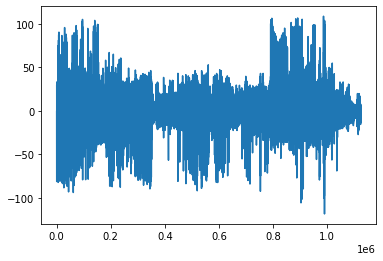

In [30]:
plt.plot(f0)
print(f0.shape)

In [31]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
print(A.shape, n_cameras, n_points)

(1125952, 333720) 89 110973


### Optimization

Scipy has existing functions for optimization that we can make use of. Write a sentence about the method that is used for optimization

In [32]:
import time
from scipy.optimize import least_squares

In [33]:
t0 = time.time()
# So far: method='lm'
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.8752e+07                                    3.32e+07    
       1              3         1.4638e+07      4.11e+06       2.28e+01       1.22e+08    
       2              5         1.4425e+07      2.12e+05       5.65e+00       1.34e+08    
       3              6         1.4424e+07      1.06e+03       1.34e+00       1.37e+08    
       4             12         1.4424e+07      0.00e+00       0.00e+00       1.37e+08    
`xtol` termination condition is satisfied.
Function evaluations 12, initial cost 1.8752e+07, final cost 1.4424e+07, first-order optimality 1.37e+08.


In [34]:
params = res.x

new_camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
new_points_3d = params[n_cameras * 9:].reshape((n_points, 3))

### Plot Optimised Points

In [35]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(new_points_3d)
o3d.visualization.draw_geometries([pcd])

Setting `scaling='jac'` was done to automatically scale the variables and equalize their influence on the cost function (clearly the camera parameters and coordinates of the points are very different entities). This option turned out to be crucial for successfull bundle adjustment.

In [36]:
print("Optimization took {0:.0f} seconds".format(t1 - t0))

Optimization took 325 seconds


Now let's plot residuals at the found solution:

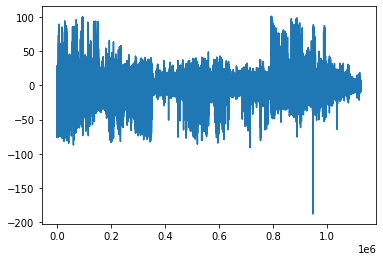

In [37]:
plt.plot(res.fun)

We see much better picture of residuals now, with the mean being very close to zero. There are some spikes left. It can be explained by outliers in the data, or, possibly, the algorithm found a local minimum (very good one though) or didn't converged enough. Note that the algorithm worked with Jacobian finite difference aproximate, which can potentially block the progress near the minimum because of insufficient accuracy (but again, computing exact Jacobian for this problem is quite difficult).

### Project 2- Part B: Submission details -
You are supposed to gain understanding by playing around with the code above and submit your answers to questions asked below. You shouldn't submit this whole notebook, just copy the following cells (starting next cell up until the end of this notebook) and paste it at the end of your Project 2 notebook (already shared on GitHub classrooms, [link](https://github.com/AryanSakaria/Project_2/blob/main/Project_2.ipynb)).

# Theory

## 1. SfM pipeline (`6 mark`)

To get the context of below questions, take a look at the code above: The same questions have been asked at different places above as comments in the code.

1. `0.5 mark` **Basics** - How do we know this (`camera_ind`) information in practical setting? In other words, how do we know observations in `points_2d` belong to which camera. Explain. 
    - Ans-1 - Basics: In a practical setting, we will be working with a series of images out of which we first take the first two images. Using SIFT, we can extract the common feature points in them. Then, we estimate the fundamental and essential matrices, and eventually the rotation and translation matrices, between the two images. Now, using triangulation, we can backproject the points into 3D points. In this step, it will be known which 2D points are being backprojected into which 3D points during the procedure of doing so. In the code, this information is stored in camera_ind. Then, PnP is used with the third image and the process is repeated for the rest of the images.
    
    
2. `0.5 mark` **Basics** - How do we know this (`point_ind`) information in practical setting?  In other words, how do we know observations in `points_2d` belong to which 3D point. Explain.
    - Ans-2 - Basics: The way the 3D points were initially estimated was by backprojecting the 2D points by estimating the $R$ and $t$ matrices and the projection matrix $K[R|t]$. So, we can keep track of which 2D point belongs to which 3D point by assigning them indices as labels.
    
    
3. `0.5 mark` **Transformations** - `rotate()` function: Why do we use the rodriquez formula? How is this representation different from the standard 3x3 Rotation matrix, why do we use this instead?
    - Ans-3 - Transformations: The Rodriguez formula is used to rotate a vector in 3D space given the axis of rotation as a unit vector $\mathbf{n}$ and the angle of rotation as $\theta$. If we consider a standard rotation matrix $R$, the rotated vector $v'$ is given by
    
    $v' = Rv$
    
    If we take the Rodriguez formula, the rotated vector $v'$ is given by
    
    $v' = vcos\theta + (k $ X $ v)sin\theta + k(k $ . $ v)(1 - cos\theta)$
    
    We do this because switching from Rotation Matrix to Axis-Angle notation for rotations reduces the number of parameters.

    
4. `0.5 mark` **Transformations** - `project()` function: In the `project()` function, would it make any difference if I do translate first, then rotate? Why/why not?
    - Ans-4 - Transformations: Yes. Rotation must be applied first, before transformation. This is because we need to first rotate the point from the world frame into the camera frame. Then translation is applied to adjust the offset of the origin or center. The translation vector itself is in the frame of the camera.
        
        
5. `0.5 mark` **Jacobian** - `bundle_adjustment_sparsity()` function: m above is not "M*N" (*2) unlike our lecture notes. Why is that so?
    - Ans-5 - Jacobian: We calculate the difference between the reprojected 2D points and the observed 2D points from the images. Each point has an $x$ and a $y$ coordinate. The Jacobian's rows correspond to residuals, hence the number of rows corresponds to twice the number of coordinates. In the lecture notes, we assumed that all $N$ points were present in $M$ images, for a total of $MN$ points and $2MN$ rows. Here, the number of 2D points will be the same as the number of elements in camera_indices, and the number of rows will be twice of that.
    
6. `2 mark` **Jacobian & Parameters** - `bundle_adjustment_sparsity()` function: 
    1.  Why are we doing `n_cameras * 9` here instead of `n_cameras * 12`? Recollect: Every individual motion Jacobian was (1*)12 in our lecture notes. 
        - Ans 6.1 - Jacobian & Parameters: The $9$ and $12$ being multiplied to the number of cameras represent the number of camera parameters. In our lecture notes, the projection matrix for the camera was given by a $3x4$ matrix $P = K[R|t]$ where $R$ is a $3x3$ rotation matrix, $t$ is a $3x1$ translation matrix and $K$ is $3x3$ calibration matrix of intrinsic features. A total of $12$ parameters were needed per camera. Here, we only need $9$ parameters which are $3$ for translation, $1$ for focal length, $2$ distortion parameters and $3$ for axis angle representation of rotation. Hence, number of parameters decreases.
        
    2. Ignoring the scale parameters, what was the number of unknown parameters in our lecture notes in terms of `n_cameras` and `n_points`? What is it here in the code? Is it different? If so, what is and why? [Link of notes](https://www.notion.so/Stereo-Structure-from-Motion-9fdd81e4194f4803ac9ba7552df56470).
        - Ans 6.2 - Jacobian & Parameters: In our lecture notes, the number of unknown parameters was $12x$n_cameras $+$ $3x$n_points. The second term is because each point an $x, y,$ and $z$ coordinate. This remains the same. The first term is because we need to estimate $12$ camera parameters since we are estimating the $3x4$ projection matrix $P=K[R|t]$as mentioned in the previous answer. In the code, the number of unknown paramters is $9x$n_cameras $+$ $3x$n_points since we need to estimate $9$ camera parameters, which are $3$ for translation, $1$ for focal length, $2$ distortion parameters and $3$ for axis angle representation of rotation. The difference is because of switching to axis angle representation instead of rotation matrix, as well as individual camera parameters instead of the calibration matrix.
            
            
7. `6 mark` **Sparsity, Residual Vector & Jacobian** - `bundle_adjustment_sparsity()` function: Explain what you understand from above 6 lines of code by coding a simple toy example yourself to illustrate how it is different from what you've learnt in class. ([Coding toy example + elaborating in words]- both are compulsory.) For the toy example, you can take something like 3 points all seen from 3 cameras. (You don't actually have to code much, just need to call the existing function) Write that toy example after this cell
    - Ans 6 - Sparsity, Residual Vector & Jacobian: As explained in the previous answers, we first compute m and n, the number of rows and columns of the Jacobian. Then, the `scipy` optimization utilises the fact that the Jacobian will be very sparse, by marking the elements which may not always be zero. Taking two rows into consideration at a time, we mark the 9 columns of the corresponding camera parameters as $1$. Next, we mark the 3 columns corresponding to 3D coordinates of that observation as $1$. The remaining elements will be zero since they come from cameras and 3D points not corresponding to this observation. This is done for all observations.

## 2. Initializing R,t and 3D points for SfM given 2 images (`4 mark`)

Using OpenCV functions, mention how you would initialize R,t (poses) and 3D points for SfM given 2 images and K matrix. You don't need to implement it, just mention function names with input/output arguments clearly and briefly explain what they do (You don't need to give detailed answers).

The first step is feature matching. Using SIFT, we get the keypoints and descriptions for `img1` and `img2`.

sift = cv2.SIFT_create()

key1, desc1 = sift.detectAndCompute(img1, None)

key2, desc2 = sift.detectAndCompute(img2, None)

Next, using K Nearest Neighbour, we match the nearest features between images.

KNN = cv2.FlannBasedMatcher({'algorithm': 0, 'trees': 5}, {'checks': 32})

matching_points = KNN.knnMatch(desc1, desc2, k=2)
____________________________________________________________________________________________________________________

Next, we separate matching points into those in the `img1` (pts1) and those in `img2` (pts2). This gives us corresponding points.

pts1 = np.array([key1[mp[0].queryIdx].pt for mp in matching_points])

pts2 = np.array([key2[mp[0].trainIdx].pt for mp in matching_points])
____________________________________________________________________________________________________________________

Using pts1, pts2 and the camera intrinsics K, we can find the essential matrix E using cv2.findEssentialMat. This can be done by setting the method to cv2.RANSAC.
____________________________________________________________________________________________________________________

The essential matrix is then decomposed into R and t.

Rt = cv2.recoverPose(E, pts1, pts2, K)

R = Rt[1]

t = Rt[2]
____________________________________________________________________________________________________________________

Then, the 3D points are calculated.

P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))

P2 = K @ np.hstack((R, t))

world_points = cv2.triangulatePoints(P1, P2, pts1, pts2)

world_points = world_points / world_points[3]

ans = world_points[:3]